<a href="https://colab.research.google.com/github/petroDavydov/goit-DeepLearningForComputerVisionAndNLP/blob/main/eda_pinguinius_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

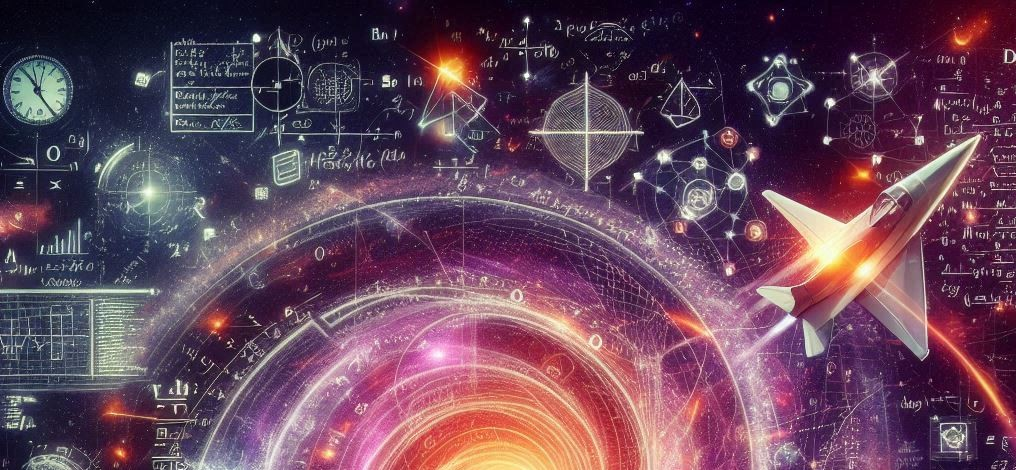

# ***Second variant Pinguins on GPU/cuda***

Використовуємо пристрій: cuda
Epoch [50/400] Train Loss: 0.9557 Train Acc: 54.71%
Epoch [100/400] Train Loss: 0.7826 Train Acc: 78.03%
Epoch [150/400] Train Loss: 0.6412 Train Acc: 79.82%
Epoch [200/400] Train Loss: 0.5291 Train Acc: 81.17%
Epoch [250/400] Train Loss: 0.4431 Train Acc: 89.24%
Epoch [300/400] Train Loss: 0.3780 Train Acc: 91.03%
Epoch [350/400] Train Loss: 0.3280 Train Acc: 91.93%
Epoch [400/400] Train Loss: 0.2887 Train Acc: 92.83%



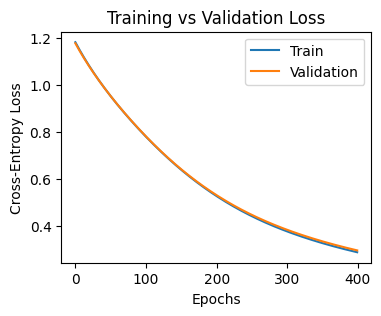

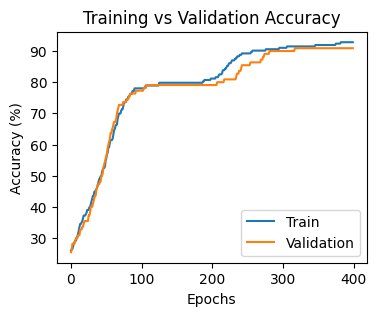

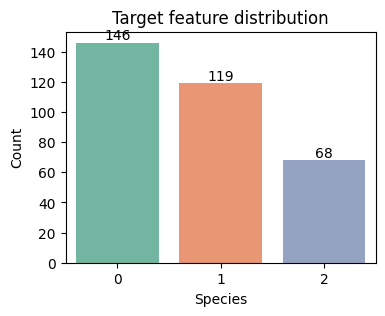

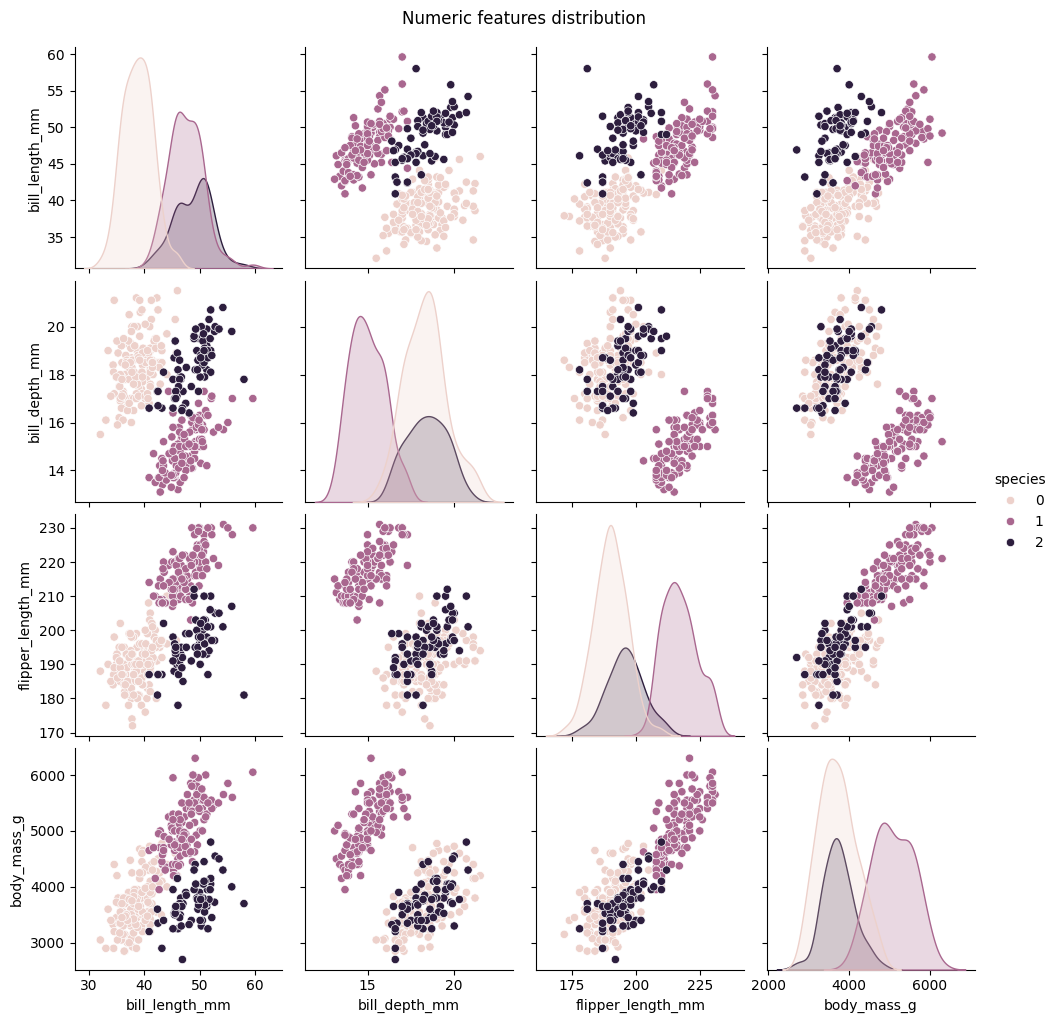


Final Test Accuracy: 90.91%


In [10]:
from dataclasses import dataclass
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# --- Вибір пристрою ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Використовуємо пристрій:", device)

# --- Завантаження даних ---
df = pd.read_csv('./Module_2_Lecture_2_Class_penguins.csv')
df = df.dropna().reset_index(drop=True)

# --- Підготовка ознак ---
features = ['species', 'bill_length_mm',
            'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
df = df.loc[:, features]

df.loc[df['species'] == 'Adelie', 'species'] = 0
df.loc[df['species'] == 'Gentoo', 'species'] = 1
df.loc[df['species'] == 'Chinstrap', 'species'] = 2
df = df.apply(pd.to_numeric)

X = df.drop('species', axis=1).values
y = df['species'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.33, stratify=y
)

# --- Перетворення у тензори та перенесення на GPU ---
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# --- Модель ---


class LinearModel(nn.Module):
    def __init__(self, in_dim, hidden_dim=20, out_dim=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)   # без Softmax
        )

    def forward(self, x):
        return self.features(x)


model = LinearModel(X_train.shape[1], 20, 3).to(device)

# --- Функція втрат та оптимізатор ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# --- Тренування ---
num_epoch = 400
train_loss, test_loss = [], []
train_accs, test_accs = [], []

for epoch in range(num_epoch):
    # Train
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    train_loss.append(loss.detach().cpu().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = 100 * torch.sum(y_train == torch.argmax(outputs,
                          dim=1)).double() / len(y_train)
    train_accs.append(acc.cpu())

    # Test
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
        test_loss.append(loss.detach().cpu().numpy())

        acc = 100 * torch.sum(y_test == torch.argmax(outputs,
                              dim=1)).double() / len(y_test)
        test_accs.append(acc.cpu())

    if (epoch+1) % 50 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epoch}] Train Loss: {train_loss[-1]:.4f} Train Acc: {train_accs[-1]:.2f}%")

# --- Графіки тренування ---
print()
plt.figure(figsize=(4, 3))
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training vs Validation Loss')
plt.show()
print()
plt.figure(figsize=(4, 3))
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.show()
print()
# --- Розподіл цільової змінної ---
plt.figure(figsize=(4, 3))
ax = sns.countplot(data=df, x='species', palette="Set2")
for container in ax.containers:
    ax.bar_label(container)
ax.set_xlabel("Species")
ax.set_ylabel("Count")
plt.title("Target feature distribution")
plt.show()
print()
# --- island, треба залишити у features ---
if 'island' in df.columns:
    plt.figure(figsize=(4, 3))
    ax = sns.countplot(data=df, x='island', palette="Set1")
    for container in ax.containers:
        ax.bar_label(container)
    ax.set_xlabel("Island")
    ax.set_ylabel("Count")
    plt.title("Island feature distribution")
    plt.show()
print()
# --- Попарний розподіл числових ознак ---
g = sns.pairplot(data=df, hue='species', height=2.5)
g.fig.suptitle('Numeric features distribution', y=1.02)
plt.show()
print()
# --- Остаточна точність ---
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    acc = 100 * torch.sum(y_test == torch.argmax(outputs,
                          dim=1)).double() / len(y_test)
    print(f"Final Test Accuracy: {acc.item():.2f}%")
